In [356]:
!pip install torch torchvision torchinfo torchmetrics tqdm

In [357]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision,\
                                        MulticlassRecall, MulticlassPrecisionRecallCurve, MulticlassConfusionMatrix,\
                                        MulticlassF1Score, MulticlassFBetaScore, MulticlassRecall, MulticlassROC

from sklearn.metrics import classification_report

from tqdm.auto import tqdm
from torchinfo import summary

%matplotlib inline
sns.set()

print(f'Torch Verison: {torch.__version__}')
print(f'Torchvision Verison: {torchvision.__version__}')
print(f'TorchMetrics Version: {torchmetrics.__version__}')

Torch Verison: 1.11.0
Torchvision Verison: 0.12.0
TorchMetrics Version: 0.10.0


In [358]:
# train_transform = transforms.Compose([
#     transforms.RandomRotation(degrees=360),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.RandomAffine(degrees=0, scale=(.8, 2)),
#     transforms.RandomAffine(degrees=0, shear=(-10, 10, -10, 10)),
#     transforms.RandomVerticalFlip(p=0.3),
#     transforms.RandomHorizontalFlip(p=0.3),
#     transforms.RandomInvert(p=0.3),
#     transforms.RandomSolarize(threshold=128, p=0.3),
#     transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
#     transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
#     transforms.RandomApply([
#         transforms.ColorJitter(brightness=0.5, hue=0.3),
#         transforms.GaussianBlur(kernel_size=(3,5), sigma=(0.1, 2))
#     ], p=0.5),
#     transforms.TrivialAugmentWide(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.49139968, 0.48215827, 0.44653124], [
#                          0.24703233, 0.24348505, 0.26158768])
# ])

# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.49139968, 0.48215827, 0.44653124], [
#                          0.24703233, 0.24348505, 0.26158768])
# ])

In [359]:
cifar_trainset = torchvision.datasets.CIFAR10(
    root='./dataset', train=True, download=True, transform=transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10), transforms.ToTensor()]))
cifar_testset = torchvision.datasets.CIFAR10(
    root='./dataset', train=False, transform=transforms.ToTensor())

Files already downloaded and verified


In [360]:
print(cifar_trainset.class_to_idx)
print(cifar_trainset.classes)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


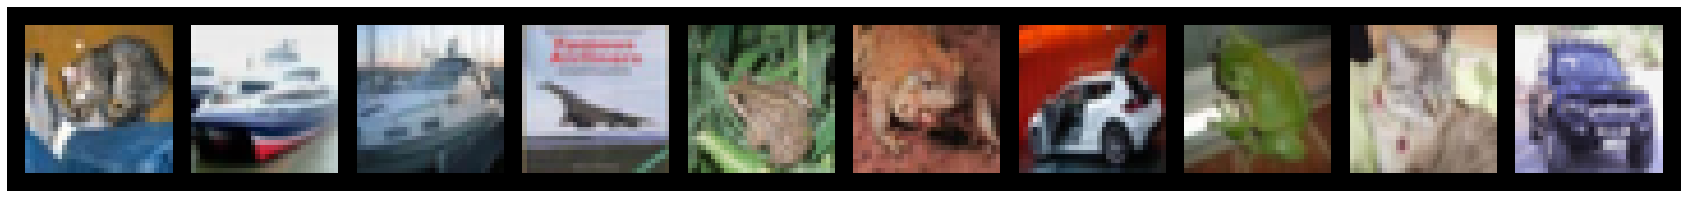

In [361]:
images, labels = zip(*[cifar_testset[i] for i in range(10)])
images = torch.stack(images)

grid = torchvision.utils.make_grid(images, nrow=10, padding=4)

fig, ax = plt.subplots(figsize=(30, 30))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

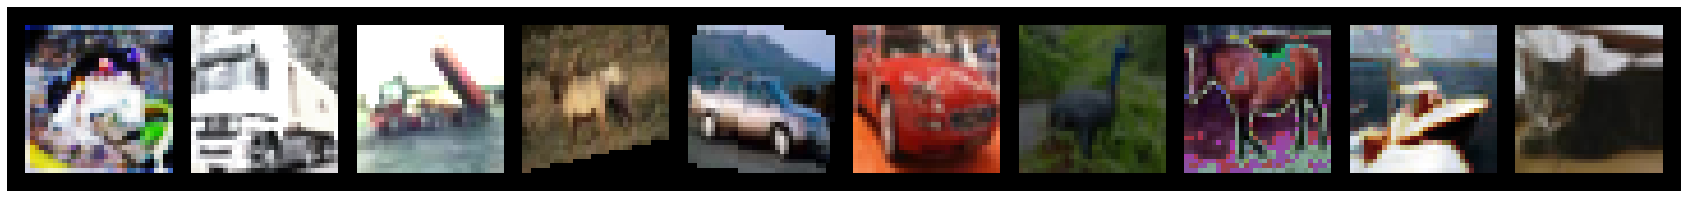

['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat']


In [362]:
images, labels = zip(*[cifar_trainset[i] for i in range(10)])
images = torch.stack(images)

grid = torchvision.utils.make_grid(images, nrow=10, padding=4)

fig, ax = plt.subplots(figsize=(30, 30))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()
print([cifar_trainset.classes[label] for label in labels])

In [363]:
EPOCHS = 32
BATCH_SIZE = 32
LEARNING_RATE = 0.1
CLASSES = 10
CHANNELS = 3
WIDTH = 32
HEIGHT = 32

In [364]:
train_loader = DataLoader(cifar_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
valid_loader = DataLoader(cifar_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

In [365]:
class CNN(nn.Module):
    def __init__(self, channels, classes) -> None:
        super(CNN, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=96, kernel_size=5, stride=1, padding=2, dilation=1, bias=False),
            nn.BatchNorm2d(num_features=96),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=80, kernel_size=5, stride=1, padding=2, dilation=1, bias=False),
            nn.BatchNorm2d(num_features=80),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=80, out_channels=96, kernel_size=5, stride=1, padding=2, dilation=1, bias=False),
            nn.BatchNorm2d(num_features=96),
            nn.LeakyReLU(0.1),
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=64, kernel_size=5, stride=1, padding=2, dilation=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.1),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64 * WIDTH // 4 * HEIGHT // 4, out_features=256),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=256, out_features=classes)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)

        x = torch.flatten(x, start_dim=1)

        x = self.classifier(x)

        return x

In [366]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [367]:
model = CNN(CHANNELS, CLASSES).to(device)
summary(model=model, input_size=[BATCH_SIZE, CHANNELS, WIDTH, HEIGHT], device=device, col_names=["input_size", "output_size", "num_params", "trainable", "kernel_size"], depth=3)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable                 Kernel Shape
CNN                                      [32, 3, 32, 32]           [32, 10]                  --                        True                      --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 96, 16, 16]          --                        True                      --
│    └─Conv2d: 2-1                       [32, 3, 32, 32]           [32, 96, 32, 32]          7,200                     True                      [5, 5]
│    └─BatchNorm2d: 2-2                  [32, 96, 32, 32]          [32, 96, 32, 32]          192                       True                      --
│    └─LeakyReLU: 2-3                    [32, 96, 32, 32]          [32, 96, 32, 32]          --                        --                        --
│    └─MaxPool2d: 2-4                    [32, 96, 32, 32]          [32, 96, 16, 16]          --   

In [368]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=0.001, momentum=0.3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=16, gamma=0.1)

In [369]:
train_metrics_coll = MetricCollection([
    MulticlassAccuracy(num_classes=CLASSES, average="micro"),
    MulticlassPrecision(num_classes=CLASSES, average="macro"),
    MulticlassRecall(num_classes=CLASSES, average="macro"),
    MulticlassFBetaScore(num_classes=CLASSES, beta=2.0),
    MulticlassConfusionMatrix(num_classes=CLASSES),
#     MulticlassROC(num_classes=CLASSES, thresholds=None),
#     MulticlassF1Score(num_classes=CLASSES, average=None),
#     MulticlassPrecisionRecallCurve(num_classes=CLASSES, thresholds=None),
]).to(device)

valid_metrics_coll = MetricCollection([
    MulticlassAccuracy(num_classes=CLASSES, average="micro"),
    MulticlassPrecision(num_classes=CLASSES, average="macro"),
    MulticlassRecall(num_classes=CLASSES, average="macro"),
    MulticlassFBetaScore(num_classes=CLASSES, beta=2.0),
    MulticlassConfusionMatrix(num_classes=CLASSES),
#     MulticlassF1Score(num_classes=CLASSES, average=None),
#     MulticlassROC(num_classes=CLASSES, thresholds=None),
#     MulticlassPrecisionRecallCurve(num_classes=CLASSES, thresholds=None),
]).to(device)

train_metrics = []
valid_metrics = []

train_metrics_vals = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fBetaScore': [],
    'loss': []
}
valid_metrics_vals = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fBetaScore': [],
    'loss': []
}

In [370]:
for epoch in tqdm(range(EPOCHS), desc=None):
    train_metrics_coll.reset(), valid_metrics_coll.reset()

    model.train()
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        model.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() # no need to divide, as reduction type is mean by default
        _, prediction = torch.max(outputs.data, 1)

        '''
            Both .forward() and .update() do slightly different things. 
            The .update() method is somewhat simpler: it just updates the metric. 
            In contrast, .forward() updates the metric, 
            but it also lets us report the metric for each individual batch update

            to call forward => train_metrics(outputs, labels)
        '''
        batch_metrics = train_metrics_coll.update(outputs, labels)

    scheduler.step()
  
    train_loss /= len(train_loader)

    model.eval()
    valid_loss = 0.0
    with torch.inference_mode():
        for i, (images, labels) in enumerate(valid_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()
            _, prediction = torch.max(outputs.data, 1)

            batch_metrics = valid_metrics_coll.update(outputs, labels)
            
            if((epoch == EPOCHS - 1) and i == len(valid_loader) - 1):
                outputs = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)

                report = classification_report(preds.cpu().numpy(), labels.cpu().numpy())
                print(report)

    valid_loss /= len(valid_loader)
    
    tr_met = train_metrics_coll.compute()
    vl_met = valid_metrics_coll.compute()

    train_metrics.append(tr_met)
    valid_metrics.append(vl_met)

    train_metrics_vals['loss'].append(train_loss)
    valid_metrics_vals['loss'].append(valid_loss)

    if (not (epoch + 1) % 10) or (epoch == EPOCHS - 1):
        print(f'Epoch: {epoch + 1}')
        print(f'Train Loss: {train_loss}, Train Accuracy: {tr_met["MulticlassAccuracy"]}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {vl_met["MulticlassAccuracy"]}')

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10
Train Loss: 0.8207386972695093, Train Accuracy: 0.712448000907898
Valid Loss: 0.8756314686026436, Valid Accuracy: 0.7028999924659729
Epoch: 20
Train Loss: 0.42370281414285055, Train Accuracy: 0.8554737567901611
Valid Loss: 0.47375788320653356, Valid Accuracy: 0.8410000205039978
Epoch: 30
Train Loss: 0.3310045524382255, Train Accuracy: 0.8889845013618469
Valid Loss: 0.4915730210925682, Valid Accuracy: 0.8464000225067139
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         0
           3       0.67      0.40      0.50         5
           4       0.00      0.00      0.00         1
           5       0.33      1.00      0.50         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         3
           8       0.67      1.00      0.80         2

    accuracy             

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

In [371]:
print(f"Validation Accuracy: {valid_metrics[len(valid_metrics) - 1]['MulticlassAccuracy'].item()}")

Validation Accuracy: 0.8463000059127808


In [372]:
for key, _ in train_metrics_coll.items():
    print(f'{key}: {train_metrics_coll.compute()[key]}')

MulticlassAccuracy: 0.8898847699165344
MulticlassPrecision: 0.8898337483406067
MulticlassRecall: 0.8898853659629822
MulticlassFBetaScore: 0.889840304851532
MulticlassConfusionMatrix: tensor([[4469,   24,  116,   63,   61,   15,   20,   22,  143,   66],
        [  48, 4672,   16,   27,   14,    9,   32,   14,   51,  114],
        [ 145,    9, 4278,   93,  168,  101,  116,   42,   34,   12],
        [  72,   21,  113, 4083,  115,  290,  142,   64,   56,   42],
        [  58,   10,  126,  103, 4394,   71,   97,  102,   19,   19],
        [  34,   18,  108,  312,  104, 4218,   74,   93,   13,   25],
        [  17,   19,   75,  126,   69,   64, 4559,   16,   26,   27],
        [  32,    9,   50,   82,  117,   71,   28, 4555,   14,   40],
        [ 149,   56,   25,   24,   28,   13,   15,    9, 4620,   60],
        [  69,  113,   19,   32,   20,   14,   18,   23,   59, 4632]],
       device='cuda:0')


In [373]:
for key, _ in valid_metrics_coll.items():
    print(f'{key}: {valid_metrics_coll.compute()[key]}')

MulticlassAccuracy: 0.8463000059127808
MulticlassPrecision: 0.8472157716751099
MulticlassRecall: 0.8463000059127808
MulticlassFBetaScore: 0.8454023599624634
MulticlassConfusionMatrix: tensor([[821,   5,  62,  15,  17,   6,   7,   7,  47,  13],
        [  3, 930,   2,   6,   3,   2,   4,   0,  15,  35],
        [ 23,   1, 827,  26,  46,  28,  35,  12,   2,   0],
        [ 12,   2,  71, 596,  60, 159,  63,  26,   7,   4],
        [  5,   0,  58,  24, 861,  12,  19,  18,   3,   0],
        [  5,   0,  33,  79,  38, 779,  31,  28,   7,   0],
        [  3,   0,  29,  23,   9,  12, 915,   3,   4,   2],
        [  6,   0,  21,  15,  40,  18,   3, 893,   3,   1],
        [ 17,   4,  17,   5,   3,   2,   5,   3, 936,   8],
        [ 13,  38,   4,   3,   6,   6,   4,   5,  16, 905]], device='cuda:0')


In [374]:
plt.rcParams["figure.figsize"] = (20, 10)

In [375]:
for metric in train_metrics:
    train_metrics_vals['accuracy'].append(metric['MulticlassAccuracy'].cpu())
    train_metrics_vals['precision'].append(metric['MulticlassPrecision'].cpu())
    train_metrics_vals['recall'].append(metric['MulticlassRecall'].cpu())
    train_metrics_vals['fBetaScore'].append(metric['MulticlassFBetaScore'].cpu())
    
for metric in valid_metrics:
    valid_metrics_vals['accuracy'].append(metric['MulticlassAccuracy'].cpu())
    valid_metrics_vals['precision'].append(metric['MulticlassPrecision'].cpu())
    valid_metrics_vals['recall'].append(metric['MulticlassRecall'].cpu())
    valid_metrics_vals['fBetaScore'].append(metric['MulticlassFBetaScore'].cpu())

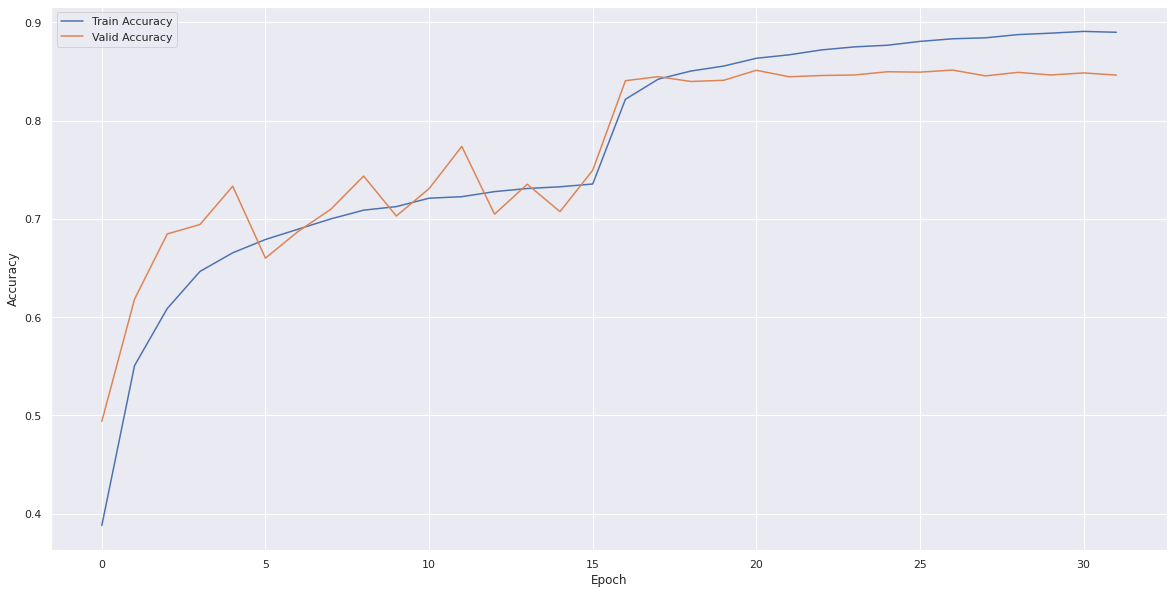

In [376]:
plt.plot(train_metrics_vals['accuracy'], label="Train Accuracy")
plt.plot(valid_metrics_vals['accuracy'], label="Valid Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

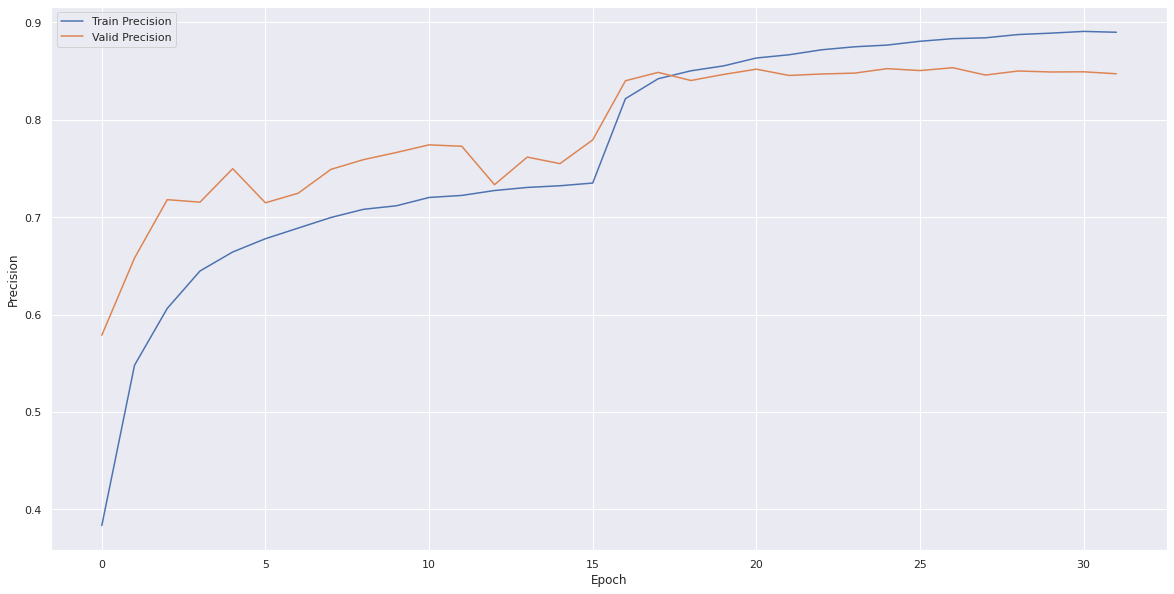

In [377]:
plt.plot(train_metrics_vals['precision'], label="Train Precision")
plt.plot(valid_metrics_vals['precision'], label="Valid Precision")

plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()
plt.show()

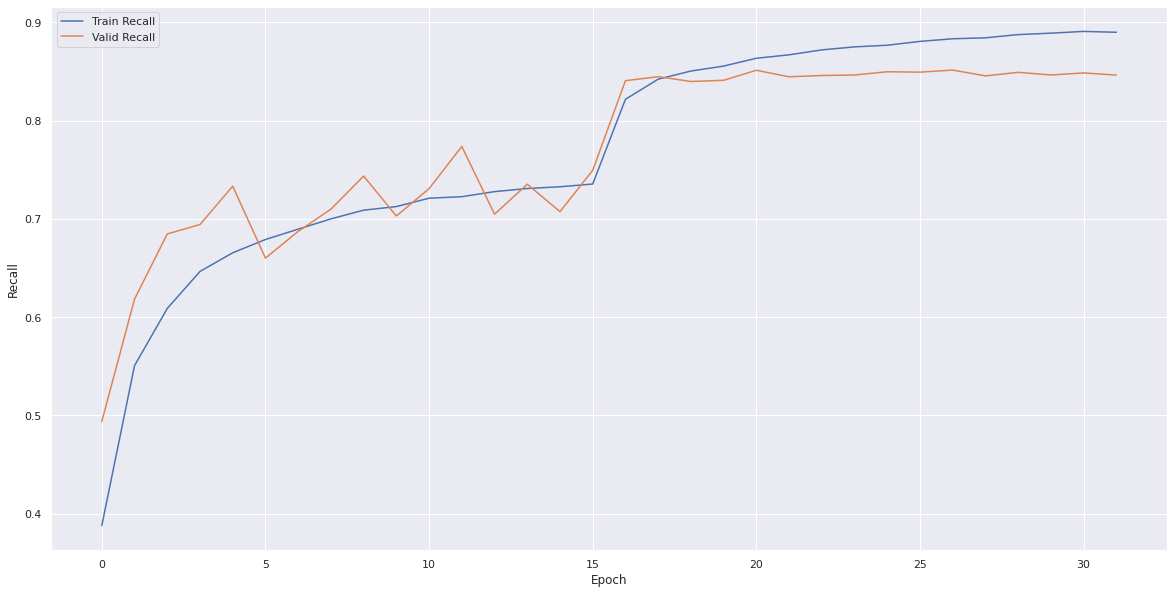

In [378]:
plt.plot(train_metrics_vals['recall'], label="Train Recall")
plt.plot(valid_metrics_vals['recall'], label="Valid Recall")

plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()

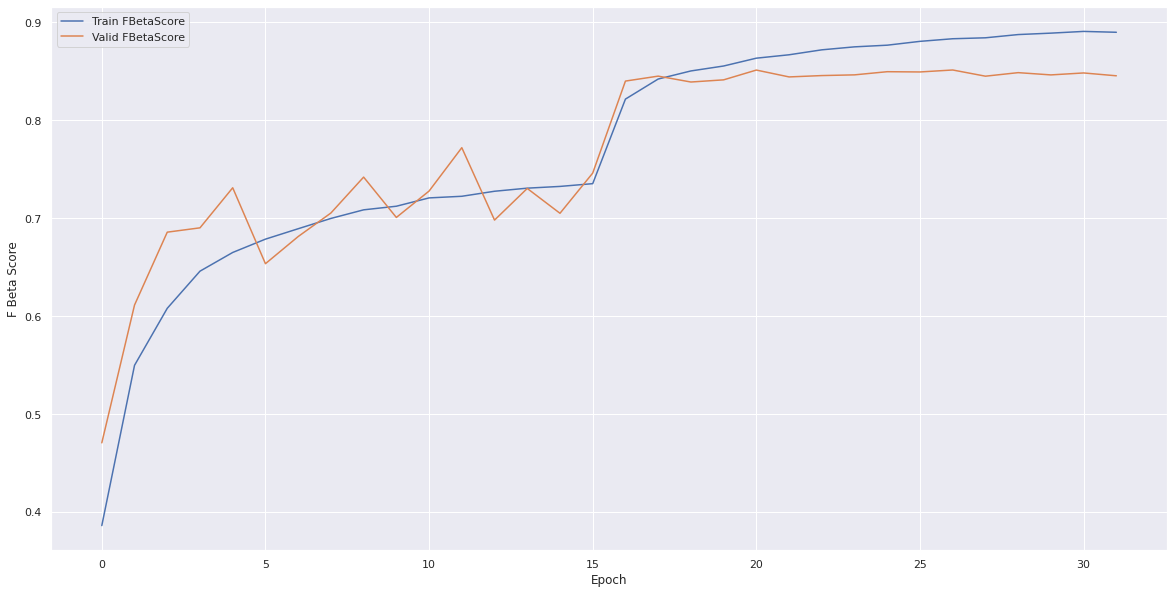

In [379]:
plt.plot(train_metrics_vals['fBetaScore'], label="Train FBetaScore")
plt.plot(valid_metrics_vals['fBetaScore'], label="Valid FBetaScore")

plt.xlabel("Epoch")
plt.ylabel("F Beta Score")
plt.legend()
plt.show()

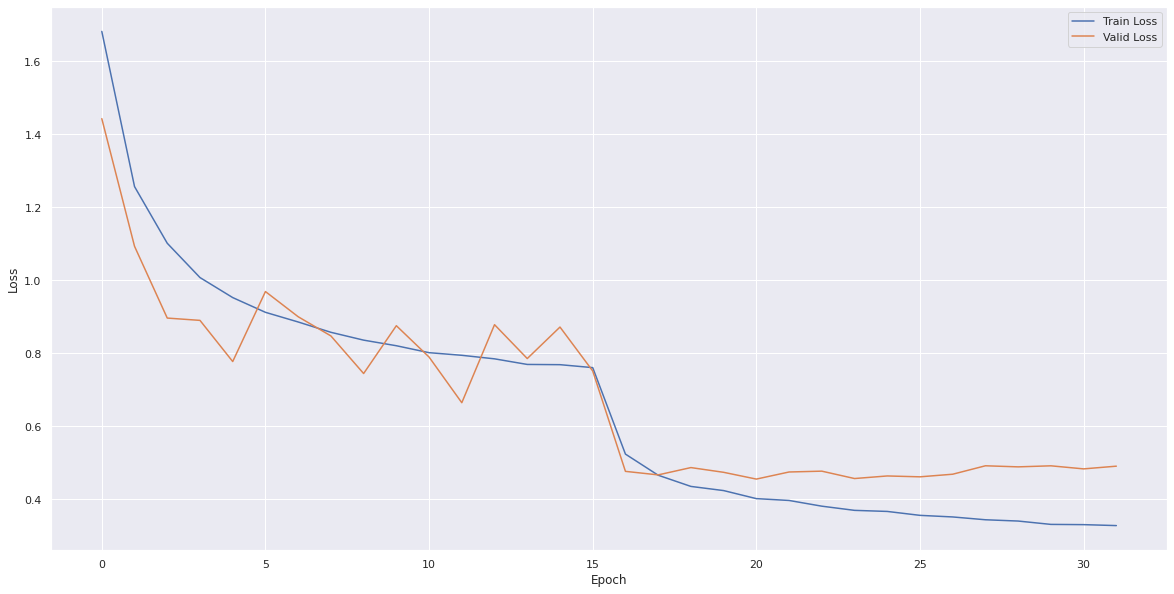

In [380]:
plt.plot(train_metrics_vals['loss'], label="Train Loss")
plt.plot(valid_metrics_vals['loss'], label="Valid Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

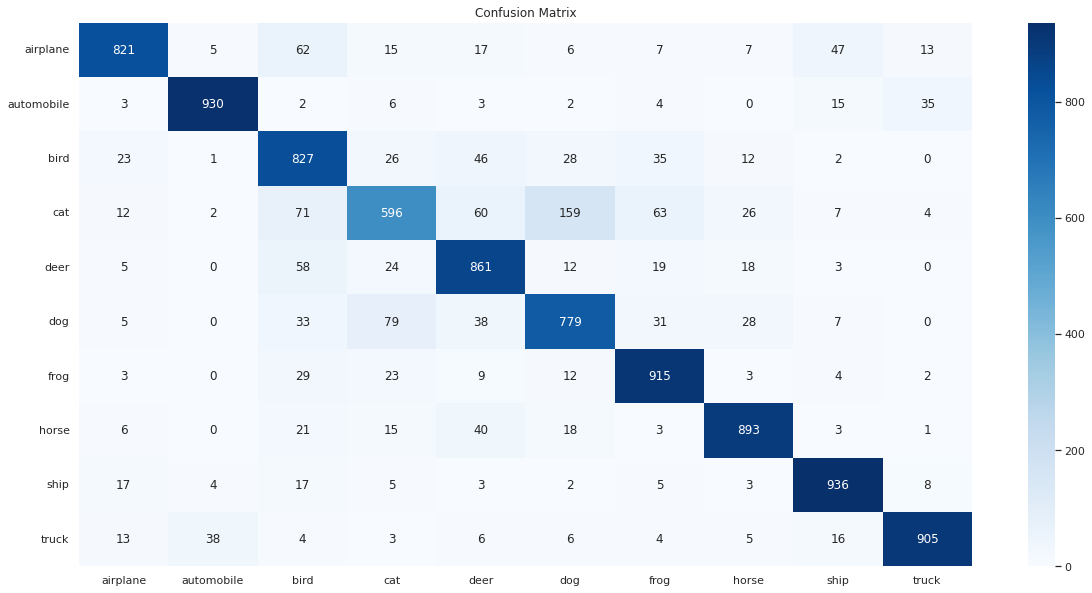

In [381]:
df_cm = pd.DataFrame(valid_metrics[len(valid_metrics) - 1]['MulticlassConfusionMatrix'].cpu().numpy(), index = cifar_trainset.classes, columns = cifar_trainset.classes)
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d').set_title('Confusion Matrix')
plt.yticks(rotation=0)
plt.show()

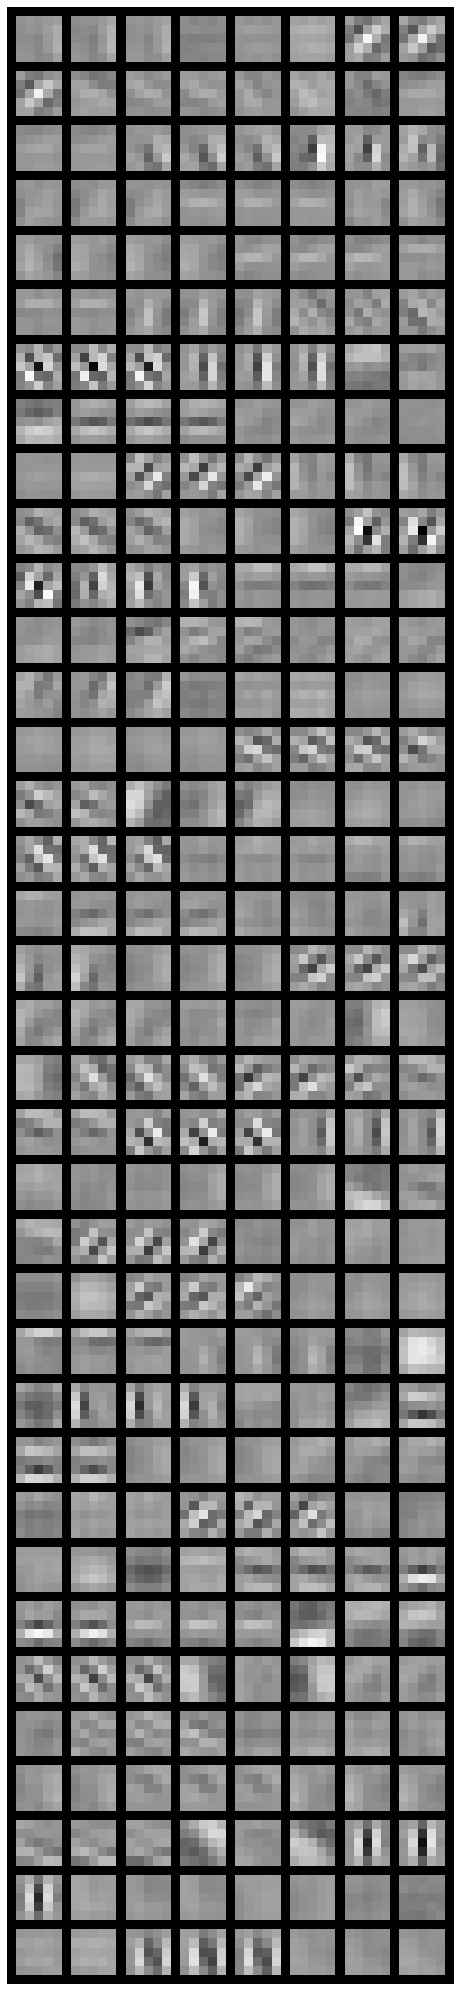

In [385]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='magma')

    plt.axis('off')
    plt.ioff()
    plt.show()


if __name__ == "__main__":
    filter = model.convblock1[0].weight.detach()
    visTensor(filter, ch=0, allkernels=True)